Chapter 1 - Multinomial BNs - Probabilistic Reasoning - Exact Reasoning

Train Survey

Age - young, adult, old <br>
Sex - male, female <br>
Education - high (high-school), university degree <br>
Occupation - emp (employee), self-employed (self) <br>
Residence - city  size: small, big <br>
Transportation - car, train, other

In [ ]:
install.packages(
  "bnlearn",
  repos = "https://cloud.r-project.org",   # CRAN mirror
  dependencies = TRUE                      # pulls in igraph, gRain, etc.
)

In [ ]:
install.packages(
  "gRain",
  repos = "https://cloud.r-project.org",   # CRAN mirror
  dependencies = TRUE                      # pulls in igraph, gRain, etc.
)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘cowplot’, ‘Deriv’, ‘doBy’, ‘litedown’, ‘gRim’, ‘markdown’, ‘microbenchmark’


Loading required package: gRbase


Attaching package: ‘gRbase’


The following objects are masked from ‘package:bnlearn’:

    ancestors, children, nodes, parents




In [76]:
library(bnlearn)
library(gRain)

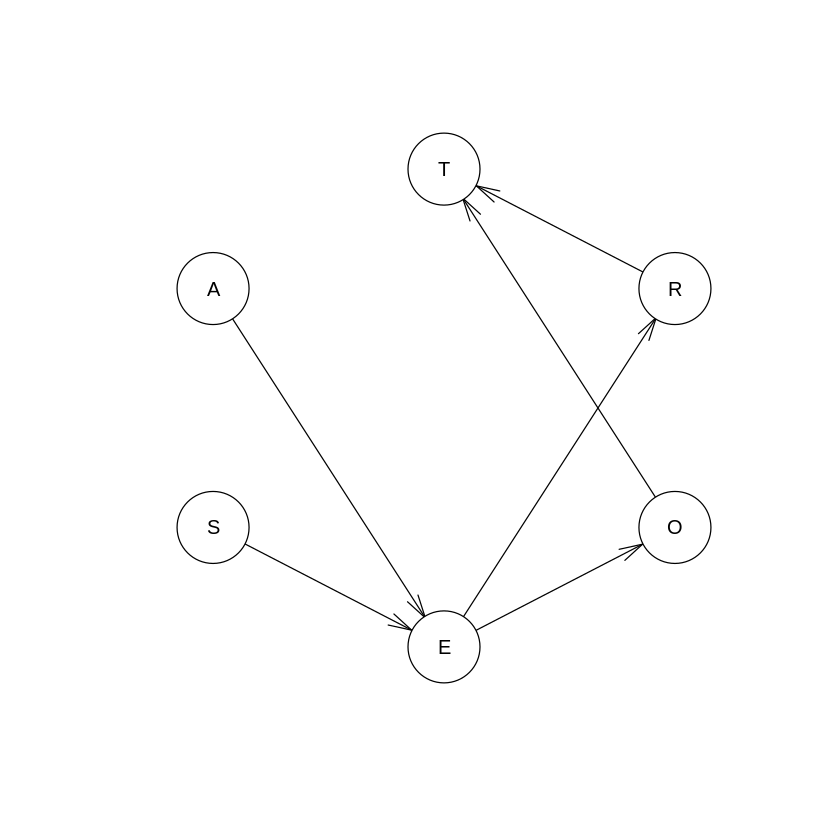

In [72]:
rm(list = ls())
setwd("/content")

# create an empty graph
dag <- empty.graph(nodes = c("A", "S", "E", "O", "R", "T"))

# Add in the edges
dag <- set.arc(dag, from = "A", to = "E") # age influences education
dag <- set.arc(dag, from = "S", to = "E") # sex influences education
dag <- set.arc(dag, from = "E", to = "O") # ....
dag <- set.arc(dag, from = "E", to = "R") # ....
dag <- set.arc(dag, from = "O", to = "T") # ....
dag <- set.arc(dag, from = "R", to = "T") # ....

plot(dag)

# Read in the data
survey <- read.table("survey.txt", header = TRUE, colClasses = "factor")


# define the states
A.lv <- c("young", "adult", "old")
S.lv <- c("M", "F")
E.lv <- c("high", "uni")
O.lv <- c("emp", "self")
R.lv <- c("small", "big")
T.lv <- c("car", "train", "other")

# specify the CPT for every node ("Expert Defined")
A.prob <- array(c(0.30, 0.50, 0.20), dim = 3, dimnames = list(A = A.lv))

S.prob <- array(c(0.60, 0.4), dim = 2, dimnames = list(S=S.lv))

O.prob <- array(c(0.96, 0.04, 0.92, 0.08), dim = c(2,2),
                dimnames = list(O=O.lv, E=E.lv))

R.prob <- array(c(0.25, 0.75, 0.20, 0.80), dim = c(2,2),
               dimnames = list(R = R.lv, E = E.lv))

E.prob <- array(c(0.75, 0.25, 0.72, 0.28, 0.88, 0.12, 0.64,
                  0.36, 0.70, 0.30, 0.90, 0.10), dim = c(2,3,2), dimnames = list(E=E.lv, A = A.lv, S = S.lv))

T.prob <- array(c(0.48, 0.42, 0.10, 0.56, 0.36, 0.08, 0.58,
                 0.24, 0.18, 0.70, 0.21, 0.09), dim = c(3,2,2),
                dimnames = list(T=T.lv, O = O.lv, R = R.lv))

cpt <- list(A = A.prob, S = S.prob, E = E.prob, O = O.prob, R = R.prob,
           T = T.prob)
bn <- custom.fit(dag, dist = cpt)

In [ ]:
# now let's think about entering information in this graph, but before that we need to
# set up and compile a junction tree; a junction tree takes the DAG and creates from it a Clique Graph
# and in a BN this Clique Graph happens to be in a Tree Structure

In [74]:
class(bn)


[1] "bn.fit"      "bn.fit.dnet"

In [77]:
junction <- compile(as.grain(bn))
junction

Independence network: Compiled: TRUE Propagated: FALSE Evidence: FALSE 

In [78]:
# probabilistic query - no information taken into account, raw data
# what is the probability of the different transportations
querygrain(junction, nodes = "T")

$T
T
      car     train     other 
0.5618340 0.2808573 0.1573088

In [79]:
querygrain(junction, nodes = "T")$T # a cleaner output

T
      car     train     other 
0.5618340 0.2808573 0.1573088

In [81]:
bn$T


  Parameters of node T (multinomial distribution)

Conditional probability table:
 
, , R = small

       O
T        emp self
  car   0.48 0.56
  train 0.42 0.36
  other 0.10 0.08

, , R = big

       O
T        emp self
  car   0.58 0.70
  train 0.24 0.21
  other 0.18 0.09


In [82]:
# What if, we want to know what is the probability of transportation when we know the passenger is female
# so now, we take this info into account and propagate it
# remember if S is d-separated from T then it's not gonna make any difference as information would not flow, but
# here we can see there is definitely a path b/w S & T
jsex <- setEvidence(junction, nodes = "S", states = "F")
jsex

Independence network: Compiled: TRUE Propagated: TRUE Evidence: TRUE 

In [83]:
# Now that the info has been propagated, what is the probability of the different transportations
querygrain(junction, nodes = "T")$T # before evidence
querygrain(jsex, nodes = "T")$T # after evidence

T
      car     train     other 
0.5618340 0.2808573 0.1573088

T
      car     train     other 
0.5620577 0.2806144 0.1573280

In [86]:
# we can see that there's not much change, so being a female doesn't really make a difference in transportation

In [85]:
# Lets look at one more query.... R = small
jres <- setEvidence(junction, nodes = "R", states = "small")

In [87]:
querygrain(jres, nodes = "T")$T # residence really has a say in transport

T
       car      train      other 
0.48388675 0.41708494 0.09902831

In [88]:
# lets take into account info on two nodes
jres_sex <- setEvidence(junction, nodes = c("R", "S"), states = c("small", "F"))
querygrain(jres_sex, nodes = "T")$T

T
       car      train      other 
0.48395358 0.41703482 0.09901161

In [90]:
# lets set evidence and query for two nodes
jedu <- setEvidence(junction, nodes = "E", states = "high") # junction tree for education
SxT <- querygrain(jedu, nodes = c("S", "T"), type = "joint") # we want to see how sex & mode of transport fare when highly educated come into picture; default type is marginal so we change to joint
SxT

,car,train,other
M,0.3426644,0.1736599,0.09623271
F,0.2167356,0.1098401,0.06086729


In [91]:
# check marginal probs
querygrain(jedu, nodes = c("S", "T"), type = "marginal")

$S
S
       M        F 
0.612557 0.387443 

$T
T
   car  train  other 
0.5594 0.2835 0.1571

In [92]:
# check the conditional probabilities
querygrain(jedu, nodes = c("S", "T"), type = "conditional")

,car,train,other
M,0.612557,0.612557,0.612557
F,0.387443,0.387443,0.387443
